# Supervised regression

The goal is to build and optimize neural networks with PyTorch with the objective of fitting a known feature in the training dataset.

The fit is achieved by minimizing the mean-squared-error between the prediction and the target features. As noticed during the presentation, by minimizing the mean-squared-error, we assume that the underlying error distribution is Gaussian. One could use the mean absolute error instead when assuming the distribution is Laplacian.


In [1]:
from typing import Tuple

# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d


We start by generating some fake dataset, which is simple enough that we can visualize the results easily. For this reason, the dataset will contain only one independent variable.

The simulated example data will be $f(x) = (3 + \kappa) x^2 + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu=0, \sigma=10)$ and $\kappa \sim \mathcal{N}(\mu=0, \sigma=0.03)$.

In this case we do know the true model, so it is interesting to take some time to pinpoint the role of $\kappa$ and $\epsilon$. These variables add fluctuation to the results. $\epsilon$ adds Gaussian noise in a way that is completely independent from $x$ and cannot be traced down to a particular functional dependence. $\kappa$ changes a specific parameter of the model, in this case the coefficient 3, by around 1%.


In [2]:
def generate_data(N: int) -> np.ndarray:
    x = 2*np.random.randn(N, 1)
    epsilon = 10*np.random.randn(N, 1)
    kappa = 0.03*np.random.randn(N, 1)
    z = (3 + kappa)*x**2 + epsilon
    return np.concatenate((x, z), axis=1).astype(np.float32)

train_data = generate_data(N=1000)

PyTorch allows you to create a class that outputs a single data entry and use that to feed input to your neural network. We will use the following class to feed the data to the neural network. This looks useless if all your data fits in a Numpy array, but notice that if you have a lot of data and cannot load it all in memory, this allows you to read data on demand, as you need it and only the needed samples are stored at a single time.

In [3]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data: np.ndarray):
        self.data = data
    def __len__(self) -> int:
        """How many samples do I have?"""
        return len(self.data)
    def __getitem__(self, idx):
        # give me item with index idx
        return {"data": self.data[idx, 0:1], "target": self.data[idx, 1:]}


In [4]:
my_dataset = MyDataset(train_data)
print(len(my_dataset))

1000


In [5]:
print(my_dataset[1])

{'data': array([0.24012195], dtype=float32), 'target': array([14.341419], dtype=float32)}


Plot some of the data:

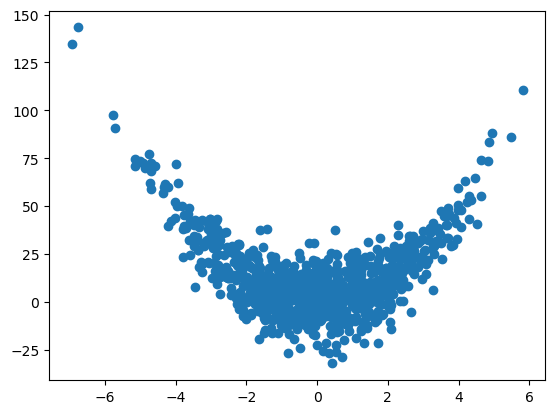

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(train_data[:, 0], train_data[:, 1])
plt.show()

And now let us define the neural network. In PyTorch, neural networks always extend `nn.Module`. They define their sub-parts in their constructor, which are convolutional layers and fully connected linear layers in this case, and the method `forward` is expected to receive an input image and output the network target.

The network parameters are the weights of the `Linear` layers, which are conveniently hidden here, but can be accessed if you try to access their `weights` elements.

In [7]:
class Network(nn.Module):
    """
        This is our parametrized function.
        It stores all the parametrized weights theta inside the model object.
        For such a simple example data, it was not necessary to have such a complex model:
        this was only done here to show the interface provided by PyTorch.
        The forward function receives the x values and outputs an estimate of the target.
        
        The nn.Sequential object allows one to apply each step in the given list of parameter
        in a sequential way. An alternative would be to create each of these layers manually
        and apply them one after the other in the forward method.
    """
    def __init__(self, input_dimension: int=1, output_dimension: int=1):
        """
        Constructor. Here we initialize the weights.
        """
        super().__init__()

        hidden_layer = 100
        self.model = nn.Sequential(
                                   nn.Linear(input_dimension, hidden_layer),
                                   nn.ReLU(),
                                   nn.Linear(hidden_layer, hidden_layer),
                                   nn.ReLU(),
                                   nn.Linear(hidden_layer, output_dimension)
                                    )

    def forward(self, x):
        """
        This function is called when one does my_network(x) and it represents the action
        of our parametrized function in the input.
        """
        return self.model(x)

Let us create one instance of this network. We also create an instance of PyTorch's `DataLoader`, which has the task of taking a given number of data elements and outputing it in a single object. This "mini-batch" of data is used during training, so that we do not need to load the entire data in memory during the optimization procedure.

We also create an instance of the Adam optimizer, which is used to tune the parameters of the network.

In [8]:
network = Network()
B = 10
loader = torch.utils.data.DataLoader(my_dataset, batch_size=B)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

/home/daniloefl/miniconda3/envs/ml/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Now we actually repeatedly try to optimize the network parameters. Each time we go through all the data we have, we go through one "epoch". For each epoch, we take several "mini-batches" of data (given by the `DataLoader` in `loader`) and use it to make one training step.

In [9]:
epochs = 100
# for each epoch
for epoch in range(epochs):
    losses = list()
    # for each mini-batch given by the loader:
    for batch in loader:
        # get the input in the mini-batch
        # this has size (B, C)
        # where B is the mini-batch size
        # C is the number of features (1 in this case)
        features = batch["data"]
        # get the targets in the mini-batch (there shall be B of them)
        target = batch["target"]
        # get the output of the neural network:
        prediction = network(features)
        
        # calculate the loss function being minimized
        # in this case, it is the mean-squared error between the prediction and the target values
        loss = F.mse_loss(prediction, target)
        # exactly equivalent to:
        #loss = ((prediction - target)**2).mean()

        # clean the optimizer temporary gradient storage
        optimizer.zero_grad()
        # calculate the gradient of the loss function as a function of the gradients
        loss.backward()
        # ask the Adam optimizer to change the parameters in the direction of - gradient
        # Adam scales the gradient by a constant which is adaptively tuned
        # take a look at the Adam paper for more details: https://arxiv.org/abs/1412.6980
        optimizer.step()
        losses.append(loss.detach().cpu().item())
    avg_loss = np.mean(np.array(losses))
    print(f"Epoch {epoch}/{epochs}: average loss {avg_loss:.5f}")

Epoch 0/100: average loss 292.65962
Epoch 1/100: average loss 168.60480
Epoch 2/100: average loss 144.85957
Epoch 3/100: average loss 131.24882
Epoch 4/100: average loss 125.56896
Epoch 5/100: average loss 122.62807
Epoch 6/100: average loss 120.44151
Epoch 7/100: average loss 118.44099
Epoch 8/100: average loss 116.76986
Epoch 9/100: average loss 115.28613
Epoch 10/100: average loss 114.02854
Epoch 11/100: average loss 112.92324
Epoch 12/100: average loss 112.03872
Epoch 13/100: average loss 111.31309
Epoch 14/100: average loss 110.73915
Epoch 15/100: average loss 110.27166
Epoch 16/100: average loss 109.91651
Epoch 17/100: average loss 109.58956
Epoch 18/100: average loss 109.31038
Epoch 19/100: average loss 109.14096
Epoch 20/100: average loss 108.96208
Epoch 21/100: average loss 108.82673
Epoch 22/100: average loss 108.67057
Epoch 23/100: average loss 108.56558
Epoch 24/100: average loss 108.45631
Epoch 25/100: average loss 108.37027
Epoch 26/100: average loss 108.29927
Epoch 27/10

Let us check what the network says about some new data it has never seen before.

In [10]:
test_data = generate_data(N=1000)

And now we can plot again the new images, now showing what the network tells us about it.

In [11]:
predicted = network(torch.from_numpy(test_data[:,0:1])).detach().numpy()

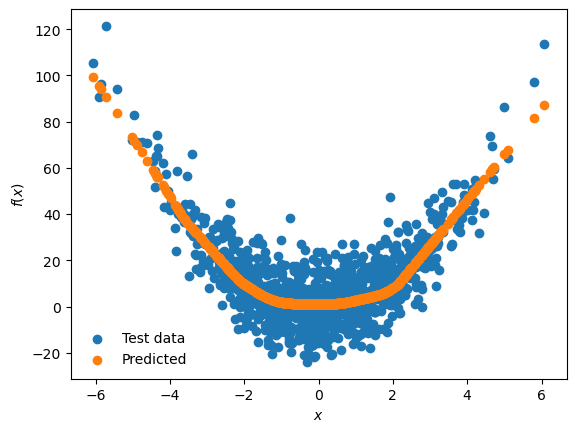

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(test_data[:, 0], test_data[:, 1], label="Test data")
ax.scatter(test_data[:, 0], predicted, label="Predicted")
ax.set(xlabel="$x$", ylabel="$f(x)$")
#ax.set_yscale('log')
plt.legend(frameon=False)
plt.show()

## What is the impact of the loss function?

What if instead of the mean squared error, you used the mean absolute error (L1 loss)? How would the result change? What does that mean for the assumptions of the model?

Try replacing `F.mse_loss` above with `F.l1_loss` or `F.huber_loss`. Look for the documentation on those losses to understand what they do.

## Regularization

You may try to apply regularization to the fit by setting the `weight_decay` argument of the optimizer. For example:

```
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3, weight_decay=1e-3)
```

This adds an extra term in the loss function proportional to the sum of square of weights, similarly to how it was discussed in the lecture.

If one wants to add other types of regularization terms to the loss function, one may also do that explicitly, by changing the way the loss function is calculated.
For example, to add an L1 regularization (absolute value of the parameters, which corresponds to the Laplace prior of parameters), one may add the following lines after calculating the loss function:

```
l1_lambda = 0.001
l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())
loss = loss + l1_lambda * l1_norm
```

Try those out!